# 目标检测7日打卡营作业三：YOLO系列模型实战

## 实战数据集及框架

- 印刷电路板（PCB）瑕疵数据集：[数据下载链接](http://robotics.pkusz.edu.cn/resources/dataset/)，是一个公共的合成PCB数据集，由北京大学发布，其中包含1386张图像以及6种缺陷（缺失孔，鼠标咬伤，开路，短路，杂散，伪铜），用于检测，分类和配准任务。我们选取了其中适用与检测任务的693张图像，随机选择593张图像作为训练集，100张图像作为验证集。
- PaddleDetection：飞桨推出的PaddleDetection是端到端目标检测开发套件，旨在帮助开发者更快更好地完成检测模型的训练、精度速度优化到部署全流程。该框架中提供了丰富的数据增强、网络组件、损失函数等模块，集成了模型压缩和跨平台高性能部署能力。目前基于PaddleDetection已经完成落地的项目涉及工业质检、遥感图像检测、无人巡检等多个领域。Github地址：https://github.com/PaddlePaddle/PaddleDetection

## 作业描述
基于PaddleDetection中的YOLO系列算法，完成印刷电路板（PCB）瑕疵数据集的训练与评估任务，在验证集上采用IoU=0.5，area=all的mAP作为评价指标，得分=mAP * 100，范围[0,100]，分数越高模型效果越好，及格线是60分。鼓励大家使用GPU训练，CPU训练的结果不纳入排行榜。

提示：
1. 增大训练轮数有助于网络收敛的更好，可提高mAP；
2. 修改Anchor尺寸以适配PCB数据集；
2. 在PaddleDetection的configs中有不同种类的YOLO系列模型，可以寻找YOLO系列性能更强的模型配置文件；
3. 可以微调网络结构，包括但不限于变换Backbone、DCNv2、iou_loss和drop_block等组件。

## Baseline基线代码
目前基线模型在GPU环境下训练36个Epoch后，mAP(IoU=0.5)达到0.401，所以还有很多优化的空间，转动你的大脑开始debug吧^-^

### 数据准备
首先将印刷电路板（PCB）瑕疵数据集与PaddleDetection代码解压到`~/work/`目录中：

In [ ]:
# 解压数据集
!tar -xf data/data52914/PCB_DATASET.tar -C ~/work/
# 解压PaddleDetection源码
!tar -xf data/data52899/PaddleDetection.tar -C ~/work/

### 环境安装
需要安装PaddleDetection所需的依赖包, 执行以下命令即可安装：

In [ ]:
%cd ~/work/PaddleDetection
! pip install -r requirements.txt
! pip install pycocotools

/home/aistudio/work/PaddleDetection
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 1.0MB 8.8MB/s eta 0:00:01
Looking in indexes: https://mirror.baidu.com/pypi/simple/
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=278356 sha256=3eaffec172acc62bdfec8f0ffd9a06164e4ad2014ca9b8e5474937cb0e011988
  Stored in directory: /home/aistudio/.cache/pip/wheels/fb/44/67/8baa69040569b1edbd7776ec6f82c387663e724908aaa60963
Successfully built pycocotools


## 修改配置文件
PaddleDetection中提供的配置文件是在8卡GPU环境下的配置，我们需要调整配置文件：
包括最大训练轮数(max_iters)，类别数(num_classes)，学习率(LearningRate)相关参数，数据Reader中TrainReader与EvalReader数据集路径等参数。

提示：
- 为保证模型正常训练不出Nan，学习率要根据GPU卡数，batch size变换而做线性变换，比如这里我们将GPU卡数8->1，所以base_lr除以8即可；（这里为了收敛更快，base_lr除以了4）
- 训练轮数与Epoch转换关系：根据训练集数量与总batch_size大小计算epoch数，然后将epoch数换算得到训练总轮数max_iters。配置文件中batch_size=8，训练集数量为593，要训练36个Epoch，在单卡GPU上训练，max_iters=593x36/8=2669。同时需要计算milestones（学习率变化界限），一般在总epoch数的2/3和8/9处进行学习率的调整，所以milestones为: [1779, 2372]。（PS：建议增大训练轮数）

### yolov3_darknet_baseline.yml配置文件修改适配：
- max_iters: 2669
- num_classes: 6
- base_lr: 0.00025
- milestones: [1779, 2372]

### yolov3_darknet_baseline.yml的Reader修改适配：
TrainReader:
- image_dir: images
- anno_path: Annotations/train.json
- dataset_dir: /home/aistudio/work/PCB_DATASET

EvalReader:
- image_dir: images
- anno_path: Annotations/val.json
- dataset_dir: /home/aistudio/work/PCB_DATASET

TestReader:
- anno_path: /home/aistudio/work/PCB_DATASET/Annotations/val.json

### Anchor重新聚类（可选）
如果网络的Anchor大小适配当前数据集，可大幅提升mAP
```
python tools/anchor_cluster.py -c ../yolov3_darknet_baseline.yml -n 9 -s 608 -m v2 -i 1000
```
具体用法和参数解释可参考[自定义数据集](https://github.com/PaddlePaddle/PaddleDetection/blob/release/0.4/docs/tutorials/Custom_DataSet.md#3%E7%94%9F%E6%88%90anchor)文档的生成Anchor章节

Anchor重新聚类完成后，修改配置文件中`YOLOv3Head`里的`anchors`字段，和TrainReader的`Gt2YoloTarget`中`anchors`字段即可。

### 数据预处理
数据扩充变换的操作在像COCO这种大规模数据集中，对提升mAP效果明显，在很小规模数据集中，如果随机数据处理操作太多，会使网络收敛速度变慢，对mAP的提升也没有帮助。所以在baseline中将非必须的随机数据增强操作注释掉了。

### 配置文件参考
如果想参考完整的配置文件，请在[https://github.com/PaddlePaddle/PaddleDetection/tree/release/0.4/configs/pcb](https://github.com/PaddlePaddle/PaddleDetection/tree/release/0.4/configs/pcb) 中查看或下载。

## 训练
如果通过以上方法修改完成配置文件后，就可以开始训练模型了：

In [ ]:
!python -u tools/anchor_cluster.py -c ../yolov3_darknet_baseline.yml -n 9 -m v2 -i 1000 -s 3100

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
100%|██████████████████████████████████████| 593/593 [00:00<00:00, 41913.35it/s]
2020-09-25 20:43:39,836-INFO: Running kmeans for 9 anchors on 2527 points...
avg_iou: 0.7999:   0%|                                 | 0/1000 [00:00<?, ?it/s]
2020-09-25 20:43:39,908-INFO: 9 anchor cluster result: [w, h]
2020-09-25 20:43:39,908-INFO: [40, 69]
2020-09-25 20:43:39,908-INFO: [66, 73]
2020-09-25 20:43:39,908-INFO: [53, 110]
2020-09-25 20:43:39,908-INFO: [106, 68]
2020-09-25 20:43:39,908-INFO: [82, 100]
2020-09-25 20:43:39,908-INFO: [62, 160]
2020-09-25 20:43:39,908-INFO: [150, 86]
2020-09-25 20:43:39,908-INFO: [111, 137]
2020-09-25 20:43:39,908-INFO: [182, 182]


In [15]:
! python -u tools/train.py -c ../yolov3_darknet_baseline.yml --use_vdl=True --vdl_log_dir=../logdir --eval
### ！！！CPU下训练执行如下指令！！！
#! python -u tools/train.py -c ../yolov3_darknet_baseline_cpu.yml --eval -o use_gpu=False pretrain_weights=../yolov3_darknet_baseline.pdparams

2020-09-25 21:49:49,413-INFO: If regularizer of a Parameter has been set by 'fluid.ParamAttr' or 'fluid.WeightNormParamAttr' already. The Regularization[L2Decay, regularization_coeff=0.000500] in Optimizer will not take effect, and it will only be applied to other Parameters!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2020-09-25 21:49:50,923-INFO: places would be ommited when DataLoader is not iterable
W0925 21:49:50.967939  6368 device_context.cc:252] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 10.1, Runtime API Version: 9.0
W0925 21:49:50.973409  6368 device_context.cc:260] device: 0, cuDNN Version: 7.6.
2020-09-25 21:49:54,435-WARNING: /home/aistudio/.cache/paddle/weights/DarkNet53_pretrained.pdparams not found, try to load model file saved with [ save_params, save_persistables, save_vars ]
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
2020-09-25 21:50:00,790-INFO: places would be ommit

### 评估与预测
训练完成后，计算效果最好模型的mAP，运行：

In [ ]:
! python -u tools/eval.py -c ../yolov3_darknet_baseline.yml \
                -o weights=output/yolov3_darknet_baseline/best_model
### ！！！CPU下执行如下指令！！！
# ! python -u tools/eval.py -c ../yolov3_darknet_baseline_cpu.yml \
#                 -o use_gpu=False weights=output/yolov3_darknet_baseline_cpu/best_model

(以下内容不计入成绩)

对印刷电路板（PCB）瑕疵数据集个别图片进行可视化预测，可以运行：

In [ ]:
! python -u tools/infer.py -c ../yolov3_darknet_baseline.yml \
                --infer_img=../PCB_DATASET/images/04_missing_hole_10.jpg \
                -o weights=output/yolov3_darknet_baseline/best_model
### ！！！CPU下执行如下指令！！！
# ! python -u tools/infer.py -c ../yolov3_darknet_baseline_cpu.yml \
#                 --infer_img=../PCB_DATASET/images/04_missing_hole_10.jpg \
#                 -o weights=output/yolov3_darknet_baseline_cpu/best_model \
#                 use_gpu=False

W0924 22:33:00.192888  1679 device_context.cc:252] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 9.2, Runtime API Version: 9.0
W0924 22:33:00.199020  1679 device_context.cc:260] device: 0, cuDNN Version: 7.6.
2020-09-24 22:33:05,873-INFO: Load categories from /home/aistudio/work/PCB_DATASET/Annotations/val.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2020-09-24 22:33:06,727-INFO: Infer iter 0
2020-09-24 22:33:06,887-INFO: Detection bbox results save in output/04_missing_hole_10.jpg


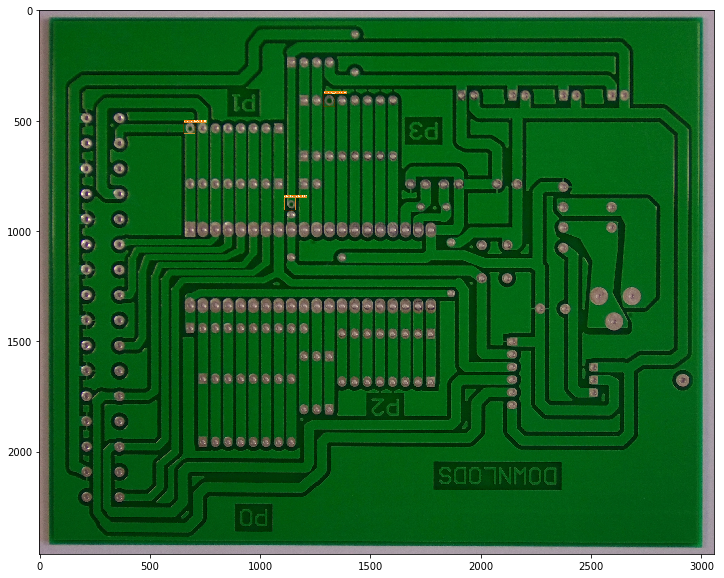

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
import cv2

infer_img = cv2.imread("output/04_missing_hole_10.jpg")
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(infer_img, cv2.COLOR_BGR2RGB))
plt.show()